In [1]:
from PIL import Image
import requests
import pandas as pd
import os
from tqdm.auto import tqdm
import glob
import multiprocessing as mp
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
from torchviz import make_dot
from ptflops import get_model_complexity_info
import time
import sys
import timm


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'Running on device: {device}')


Running on device: cuda:0


# Training Data

In [2]:
train_dir = 'D:\\W\\VS\\VS Folder\\DFD\\DFDC MTCNN Extracted\\'
train_df = pd.read_csv(os.path.join(train_dir, 'metadata.csv'))
train_df['path'] = train_df['filename'].apply(lambda x: os.path.join(train_dir, x.split('.')[0]))

# Remove empty folders
train_df = train_df[train_df['path'].map(lambda x: os.path.exists(x))]
train_df

,filename,label,split,original,path
0,aagfhgtpmv.mp4,FAKE,train,vudstovrck.mp4,D:\W\VS\VS Folder\DFD\DFDC MTCNN Extracted\aag...
1,aapnvogymq.mp4,FAKE,train,jdubbvfswz.mp4,D:\W\VS\VS Folder\DFD\DFDC MTCNN Extracted\aap...
2,abarnvbtwb.mp4,REAL,train,NaN,D:\W\VS\VS Folder\DFD\DFDC MTCNN Extracted\aba...
3,abofeumbvv.mp4,FAKE,train,atvmxvwyns.mp4,D:\W\VS\VS Folder\DFD\DFDC MTCNN Extracted\abo...
4,abqwwspghj.mp4,FAKE,train,qzimuostzz.mp4,D:\W\VS\VS Folder\DFD\DFDC MTCNN Extracted\abq...
...,...,...,...,...,...
395,etejaapnxh.mp4,FAKE,train,wtreibcmgm.mp4,D:\W\VS\VS Folder\DFD\DFDC MTCNN Extracted\ete...
396,etmcruaihe.mp4,FAKE,train,afoovlsmtx.mp4,D:\W\VS\VS Folder\DFD\DFDC MTCNN Extracted\etm...
397,etohcvnzbj.mp4,FAKE,train,bdnaqemxmr.mp4,D:\W\VS\VS Folder\DFD\DFDC MTCNN Extracted\eto...
398,eudeqjhdfd.mp4,REAL,train,NaN,D:\W\VS\VS Folder\DFD\DFDC MTCNN Extracted\eud...


In [3]:
valid_train_df = pd.DataFrame(columns=['filename', 'label', 'split', 'original', 'path'])

# for row_idx, row in tqdm(train_df.iterrows()):
for row_idx in tqdm(train_df.index):
    row = train_df.loc[row_idx]
    img_dir = row['path']
    face_paths = glob.glob(f'{img_dir}/*.png')

    if len(face_paths) >= 5: # Satisfy the minimum requirement for the number of faces
        face_indices = [
            path.split('\\')[-1].split('.')[0].split('_')[0]
            for path in face_paths
        ]
        max_idx = np.max(np.array(face_indices, dtype=np.uint32))

        selected_paths = []

        for i in range(5):
            stride = int((max_idx + 1)/(5**2))
            sample = np.linspace(i*stride, max_idx + i*stride, 5).astype(int)

            # Get faces
            for idx in sample:
                paths = glob.glob(f'{img_dir}/{idx}*.png')

                selected_paths.extend(paths)
                if len(selected_paths) >= 5: # Get enough faces
                    break

            if len(selected_paths) >= 5:  # Get enough faces
                valid_train_df = pd.concat([valid_train_df, pd.DataFrame([row])], ignore_index=True)
                break

  0%|          | 0/400 [00:00<?, ?it/s]

In [16]:
valid_train_df['label']=valid_train_df['label'].replace({'FAKE': 1, 'REAL': 0})
display(valid_train_df.head())

label_count = valid_train_df.groupby('label').count()['filename']
print(label_count)

x = valid_train_df['path'].to_numpy()
y = valid_train_df['label'].to_numpy()

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.3, random_state=224, stratify=y)

np.savez('train_test_split.npz',
         x_train=x_train,
         x_val=x_val,
         y_train=y_train,
         y_val=y_val)

C:\Users\rachi\AppData\Local\Temp\ipykernel_21020\3380636837.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  valid_train_df['label']=valid_train_df['label'].replace({'FAKE': 1, 'REAL': 0})


,filename,label,split,original,path
0,aagfhgtpmv.mp4,1,train,vudstovrck.mp4,D:\W\VS\VS Folder\DFD\DFDC MTCNN Extracted\aag...
1,aapnvogymq.mp4,1,train,jdubbvfswz.mp4,D:\W\VS\VS Folder\DFD\DFDC MTCNN Extracted\aap...
2,abarnvbtwb.mp4,0,train,NaN,D:\W\VS\VS Folder\DFD\DFDC MTCNN Extracted\aba...
3,abqwwspghj.mp4,1,train,qzimuostzz.mp4,D:\W\VS\VS Folder\DFD\DFDC MTCNN Extracted\abq...
4,acifjvzvpm.mp4,1,train,kbvibjhfzo.mp4,D:\W\VS\VS Folder\DFD\DFDC MTCNN Extracted\aci...


label
0     76
1    306
Name: filename, dtype: int64


# Training - Feature extraction and classifier

In [2]:
data = np.load('train_test_split.npz', allow_pickle=True)
x_train = data['x_train']
y_train = data['y_train']

### Model

In [2]:
# processor = EfficientNetImageProcessor.from_pretrained("google/efficientnet-b0")
model = model = timm.create_model('tf_efficientnetv2_b0.in1k', pretrained=True)
model.classifier = nn.Linear(model.classifier.in_features, 1)
# classifier = nn.Linear(768, 1)
criterion = nn.BCEWithLogitsLoss()  # For binary classification

data_config = timm.data.resolve_model_data_config(model)
transforms = timm.data.create_transform(**data_config, is_training=False)


In [4]:
print(model)


EfficientNet(
  (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): ConvBnAct(
        (conv): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (drop_path): Identity()
      )
    )
    (1): Sequential(
      (0): EdgeResidual(
        (conv_exp): Conv2dSame(16, 64, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (bn1): BatchNormAct2d(
          64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity(

In [5]:
model = model.to(device)
model.train()

# freeze model parameters
for param in model.parameters():
    param.requires_grad = False

print(len(model.blocks),"total layers")

# unfreeze n layer parameters
n = 2
for layer in model.blocks[-n:]:
    for param in layer.parameters():
        param.requires_grad = True
    display(f'Unfreezing layer: {layer}')

for param in model.classifier.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(
    list(model.classifier.parameters()) +
    [p for p in model.blocks.parameters() if p.requires_grad == True],
    lr=1e-4
)





6 total layers


'Unfreezing layer: Sequential(\n  (0): InvertedResidual(\n    (conv_pw): Conv2d(96, 576, kernel_size=(1, 1), stride=(1, 1), bias=False)\n    (bn1): BatchNormAct2d(\n      576, eps=0.001, momentum=0.1, affine=True, track_running_stats=True\n      (drop): Identity()\n      (act): SiLU(inplace=True)\n    )\n    (conv_dw): Conv2d(576, 576, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=576, bias=False)\n    (bn2): BatchNormAct2d(\n      576, eps=0.001, momentum=0.1, affine=True, track_running_stats=True\n      (drop): Identity()\n      (act): SiLU(inplace=True)\n    )\n    (aa): Identity()\n    (se): SqueezeExcite(\n      (conv_reduce): Conv2d(576, 24, kernel_size=(1, 1), stride=(1, 1))\n      (act1): SiLU(inplace=True)\n      (conv_expand): Conv2d(24, 576, kernel_size=(1, 1), stride=(1, 1))\n      (gate): Sigmoid()\n    )\n    (conv_pwl): Conv2d(576, 112, kernel_size=(1, 1), stride=(1, 1), bias=False)\n    (bn3): BatchNormAct2d(\n      112, eps=0.001, momentum=0.1, affine=True,

'Unfreezing layer: Sequential(\n  (0): InvertedResidual(\n    (conv_pw): Conv2d(112, 672, kernel_size=(1, 1), stride=(1, 1), bias=False)\n    (bn1): BatchNormAct2d(\n      672, eps=0.001, momentum=0.1, affine=True, track_running_stats=True\n      (drop): Identity()\n      (act): SiLU(inplace=True)\n    )\n    (conv_dw): Conv2dSame(672, 672, kernel_size=(3, 3), stride=(2, 2), groups=672, bias=False)\n    (bn2): BatchNormAct2d(\n      672, eps=0.001, momentum=0.1, affine=True, track_running_stats=True\n      (drop): Identity()\n      (act): SiLU(inplace=True)\n    )\n    (aa): Identity()\n    (se): SqueezeExcite(\n      (conv_reduce): Conv2d(672, 28, kernel_size=(1, 1), stride=(1, 1))\n      (act1): SiLU(inplace=True)\n      (conv_expand): Conv2d(28, 672, kernel_size=(1, 1), stride=(1, 1))\n      (gate): Sigmoid()\n    )\n    (conv_pwl): Conv2d(672, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)\n    (bn3): BatchNormAct2d(\n      192, eps=0.001, momentum=0.1, affine=True, track_runn

### Train

In [ ]:


batch_size = 24
labels = []
video_paths = x_train
video_labels = y_train
total_batches = 0


# from urllib.request import urlopen
# from PIL import Image
# import timm

# img = Image.open(urlopen(
#     'https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/beignets-task-guide.png'
# ))

# model = timm.create_model('tf_efficientnetv2_b0.in1k', pretrained=True)
# model = model.eval()

# # get model specific transforms (normalization, resize)
# data_config = timm.data.resolve_model_data_config(model)
# transforms = timm.data.create_transform(**data_config, is_training=False)

# output = model(transforms(img).unsqueeze(0))  # unsqueeze single image into batch of 1

# top5_probabilities, top5_class_indices = torch.topk(output.softmax(dim=1) * 100, k=5)


loss_path= 'efficientnetV2_B0_train_loss.npy'
model_path = 'efficientnetV2_B0.pth'


if os.path.exists(model_path):
    print("Loading existing model weights...")
    model.load_state_dict(torch.load(model_path))
    model = model.to(device)
    print("Resuming training with loaded model weights.")

else:
    print("Model weights not found, starting training...")





num_epochs = 10  # Adjust as needed
train_loss=np.zeros(num_epochs)

start_time = time.time()

epoch_bar = tqdm(range(num_epochs), desc='Epochs')
for epoch in epoch_bar:
    model.train()
    # classifier.train()

    running_loss = 0.0
    total_batches = 0

    video_bar = tqdm(zip(video_paths, video_labels),desc='Videos', total=len(video_paths))
    for path, label in video_bar:
        image_files = sorted([ os.path.join(path, f)
        for f in os.listdir(path)
        if f.lower().endswith('.png')
        ])

        labels.extend([label] * len(image_files))  # Repeat label for each image

        video_run_loss=0.0
        batches = 0

        for i in range(0, len(image_files), batch_size):
            batch_paths = image_files[i:i+batch_size]
            images = [Image.open(p).convert("RGB") for p in batch_paths]

            batch_tensor = torch.stack([transforms(img) for img in images]).to(device)

            # inputs = processor(images=images, return_tensors="pt")
            # inputs = {k: v.to(device) for k, v in inputs.items()}

            batch_labels = torch.tensor([label] * len(images), dtype=torch.float).unsqueeze(1).to(device)

            optimizer.zero_grad()

            outputs = model(batch_tensor)  # shape: [batch_size, 1]
            batch_logits = outputs
            loss = criterion(batch_logits, batch_labels)
            loss.backward()
            optimizer.step()

            loss_item = loss.item()
            running_loss += loss_item
            video_run_loss += loss_item

            batches += 1
            total_batches += 1

            

        video_loss = video_run_loss / batches if batches > 0 else 0
        video_bar.set_postfix(Last_Loss=f'{video_loss:.4f}')
        
    avg_loss = running_loss / total_batches if total_batches > 0 else 0
    train_loss[epoch] = avg_loss
    epoch_bar.set_postfix(Curr_Loss=f'{avg_loss:.4f}')

end_time = time.time()
training_time = end_time - start_time

# Save model backbone
torch.save(model.state_dict(), model_path)
# Saving training loss

if os.path.exists(loss_path):
    # loading existing training loss
    training_loss = np.load(loss_path)
    training_loss = np.concatenate((training_loss, train_loss))
    np.save(loss_path, training_loss)

else:
    training_loss = train_loss
    np.save(loss_path, training_loss)




Loading existing model weights...
Resuming training with loaded model weights.


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Videos:   0%|          | 0/267 [00:00<?, ?it/s]

Videos:   0%|          | 0/267 [00:00<?, ?it/s]

Videos:   0%|          | 0/267 [00:00<?, ?it/s]

Videos:   0%|          | 0/267 [00:00<?, ?it/s]

Videos:   0%|          | 0/267 [00:00<?, ?it/s]

Videos:   0%|          | 0/267 [00:00<?, ?it/s]

Videos:   0%|          | 0/267 [00:00<?, ?it/s]

Videos:   0%|          | 0/267 [00:00<?, ?it/s]

Videos:   0%|          | 0/267 [00:00<?, ?it/s]

Videos:   0%|          | 0/267 [00:00<?, ?it/s]

In [7]:

print(f"Training completed in {training_time/60:.2f} minutes")


Training completed in 74.02 minutes


Log Loss Graph

In [7]:
loss_path= 'efficientnetV2_B0_train_loss.npy'
training_loss = np.load(loss_path)

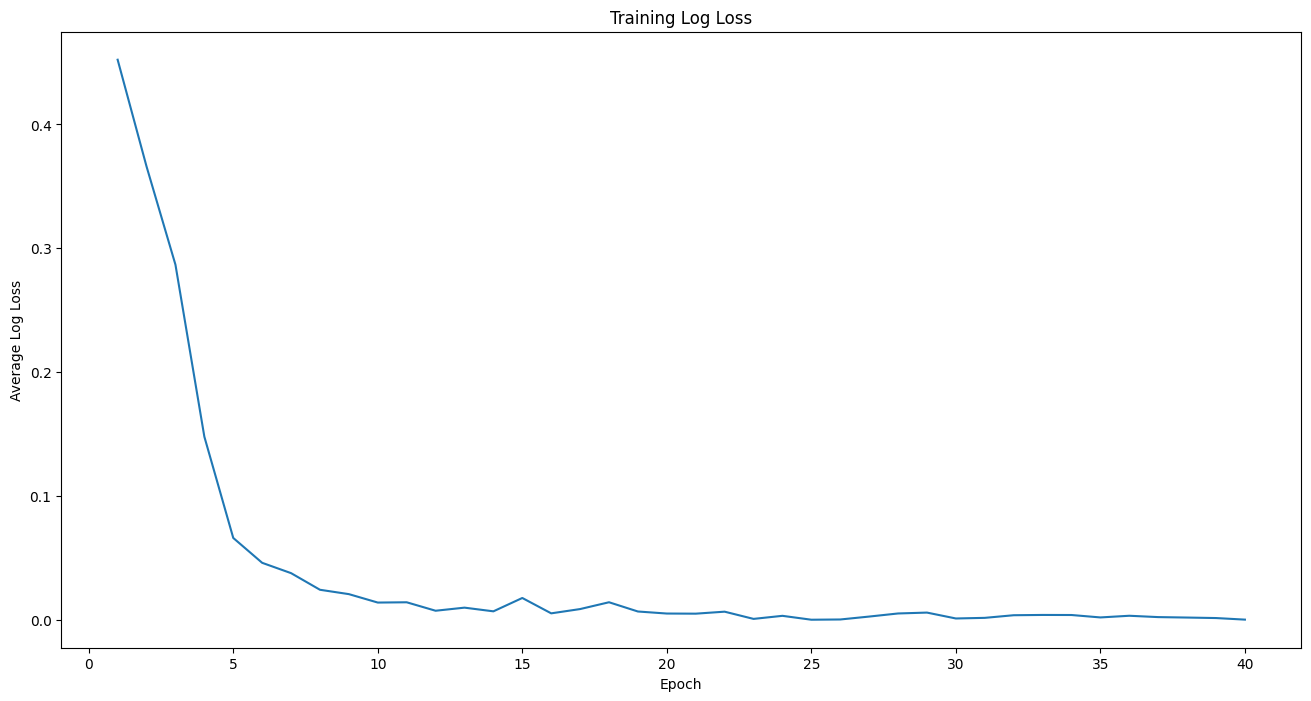

Last Training Log Loss: 0.0003


In [8]:
epochs = list(range(1, len(training_loss) + 1))
plt.figure(figsize=(16, 8))
plt.plot(epochs, training_loss)
plt.title('Training Log Loss')
plt.xlabel('Epoch')
plt.ylabel('Average Log Loss')
plt.show()

print(f"Last Training Log Loss: {training_loss[-1]:.4f}")

# Validation

In [3]:
model.load_state_dict(torch.load('efficientnetV2_B0.pth'))
# classifier.load_state_dict(torch.load('vit_classifier_head.pth'))
model = model.to(device)
# classifier = classifier.to(device)



### Model and Data

In [4]:
data = np.load('train_test_split.npz', allow_pickle=True)
x_val = data['x_val']
y_val = data['y_val']


In [6]:
batch_size = 24
video_paths = x_val
video_labels = y_val
labels = []

model.eval()
# classifier.eval()

running_loss = 0.0
total_batches = 0
total_images = 0
correct = 0
total = 0

start_time = time.time()

video_bar = tqdm(zip(video_paths, video_labels),desc='Videos', total=len(video_paths))
for path, label in video_bar:
    image_files = sorted([ os.path.join(path, f)
    for f in os.listdir(path)
    if f.lower().endswith('.png')
    ])

    labels.extend([label] * len(image_files))  # Repeat label for each image
    total_images += len(image_files)

    for i in tqdm(range(0, len(image_files), batch_size), desc='Image Batches', leave=False):
        total_batches += 1
        batch_paths = image_files[i:i+batch_size]
        images = [Image.open(p).convert("RGB") for p in batch_paths]

        batch_tensor = torch.stack([transforms(img) for img in images]).to(device)
        batch_labels = torch.tensor([label] * len(images), dtype=torch.float).unsqueeze(1).to(device)


        with torch.no_grad():
            outputs = model(batch_tensor)  # shape: [batch_size, 1]
            batch_logits = outputs

            # running_loss += criterion(batch_logits, batch_labels).item()
            running_loss=criterion(batch_logits, batch_labels).item() * batch_labels.size(0)

            preds = (torch.sigmoid(batch_logits) > 0.5).int()
            correct += (preds == batch_labels.int()).sum().item()
            total += batch_labels.size(0)

accuracy = correct / total if total > 0 else 0

# val_loss = running_loss / total_batches if total_batches > 0 else 0
val_loss = running_loss / total if total > 0 else 0

end_time = time.time()
vali_time = end_time - start_time
vali_inf_time = vali_time / total_images
vali_fps = total_images / vali_time

print(f"Validation Accuracy: {accuracy*100:.2f}%")
print(f"Validation Log Loss: {val_loss:.4f}")

print(f"Validation Time: {vali_time/60:.2f} minutes")
print(f"Validation Single Inference Time: {vali_inf_time:.2f} seconds")
print(f"Validation FPS: {vali_fps:.2f} images/second")





Videos:   0%|          | 0/115 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/28 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/26 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/26 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/29 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/15 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/11 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/15 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/26 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/30 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/26 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/26 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/24 [00:00<?, ?it/s]

Validation Accuracy: 80.01%
Validation Log Loss: 0.0045
Validation Time: 2.03 minutes
Validation Single Inference Time: 0.00 seconds
Validation FPS: 318.28 images/second


Measuring Gflops

In [6]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params / 1e6:.2f}M")

Total parameters: 5.86M


In [7]:
from thop import profile
input_tensor = torch.randn(1, 3, 224, 224).to(device)
tmacs, tparams = profile(model, inputs=(input_tensor,))
print(f"Params: {tparams / 1e6:.2f}M, GFLOPs: {2*tmacs / 1e9:.2f}")

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
Params: 5.74M, GFLOPs: 1.30
